In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import csv

print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2025-08-15 17:41:25.144407: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.2
1 Physical GPUs, 1 Logical GPUs


2025-08-15 17:41:28.302681: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-15 17:41:30.758993: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-15 17:41:30.759036: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-15 17:41:30.760137: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-15 17:41:30.760208: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

In [39]:
imageFileNames = tf.data.Dataset.list_files('./images/*', shuffle=False)

allLabelDict = {}

labelSet = set()
cellShapeSet = set()
nucleusShapeSet = set()
cytoplasmVacuoleSet = set()

with open("./dev_data_2025.csv", "r") as f:
	csvItems = list(csv.DictReader(f))
	for imgLabel in csvItems:
		labelSet.add(imgLabel['label'])
		cellShapeSet.add(imgLabel['cell_shape'])
		nucleusShapeSet.add(imgLabel['nucleus_shape'])
		cytoplasmVacuoleSet.add(imgLabel['cytoplasm_vacuole'])

	labelTuple = tuple(labelSet)
	cellShapeTuple = tuple(cellShapeSet)
	nucleusShapeTuple = tuple(nucleusShapeSet)
	cytoplasmVacuoleTuple = tuple(cytoplasmVacuoleSet)
	
	for imgLabel in csvItems:
		allLabelDict[imgLabel['imageID']] = [
			labelTuple.index(imgLabel['label']), 
			cellShapeTuple.index(imgLabel['cell_shape']), 
			nucleusShapeTuple.index(imgLabel['nucleus_shape']), 
			cytoplasmVacuoleTuple.index(imgLabel['cytoplasm_vacuole'])
		]

print(labelTuple)
print(cellShapeTuple)
print(nucleusShapeTuple)
print(cytoplasmVacuoleTuple)
print(allLabelDict)

('Lymphocyte', 'Eosinophil', 'Monocyte', 'Neutrophil', 'Basophil')
('irregular', 'round')
('unsegmented-round', 'irregular', 'segmented-multilobed', 'unsegmented-band', 'unsegmented-indented', 'segmented-bilobed')
('yes', 'no')
{'Img_00001': [0, 1, 0, 1], 'Img_00002': [2, 0, 4, 1], 'Img_00003': [2, 0, 1, 0], 'Img_00004': [4, 1, 2, 1], 'Img_00005': [3, 1, 3, 1], 'Img_00006': [1, 1, 5, 1], 'Img_00007': [3, 1, 3, 1], 'Img_00008': [3, 1, 3, 1], 'Img_00009': [3, 1, 3, 1], 'Img_00010': [3, 1, 3, 1], 'Img_00011': [0, 1, 4, 1], 'Img_00012': [3, 1, 3, 1], 'Img_00013': [4, 1, 1, 1], 'Img_00014': [3, 1, 5, 1], 'Img_00015': [2, 0, 4, 0], 'Img_00016': [2, 0, 0, 0], 'Img_00017': [1, 1, 2, 1], 'Img_00018': [1, 1, 5, 1], 'Img_00019': [0, 1, 4, 1], 'Img_00020': [1, 1, 5, 1], 'Img_00021': [3, 0, 3, 1], 'Img_00022': [4, 1, 1, 1], 'Img_00023': [2, 1, 4, 1], 'Img_00024': [4, 1, 2, 1], 'Img_00025': [3, 1, 3, 1], 'Img_00026': [1, 1, 5, 1], 'Img_00027': [3, 1, 3, 1], 'Img_00028': [0, 1, 0, 1], 'Img_00029': [1

In [44]:
def getLabel(path):
	path = path.numpy().decode("utf-8")
	key = os.path.basename(path)[:9]
	
	if key not in allLabelDict:
		print("Missing key:", key)
		raise ValueError("Missing label key.")
	return tf.convert_to_tensor(allLabelDict[key], dtype=tf.uint8)

def getImage(path):
	img = tf.io.read_file(path)
	img = tf.io.decode_jpeg(img, channels=3)
	return tf.image.resize_with_crop_or_pad(img, 360, 360)

def processData(file_path):
	label = tf.py_function(func=getLabel, inp=[file_path], Tout=tf.uint8)
	label.set_shape([4])

	img = tf.py_function(func=getImage, inp=[file_path], Tout=tf.uint8)
	img.set_shape([360, 360, 3])

	return img, label

def labelsToDict(img, label):
	labelDict = {
		"labelOutput": tf.convert_to_tensor([label[0]]),
    "cellShapeOutput": tf.convert_to_tensor([label[1]]),
    "nucleusShapeOutput": tf.convert_to_tensor([label[2]]),
    "cytoplasmVacuoleOutput": tf.convert_to_tensor([label[3]])
	}

	return img, labelDict


valSize = int(imageFileNames.cardinality().numpy() * 0.2)

trainData = imageFileNames \
  .skip(valSize) \
  .map(processData, num_parallel_calls=tf.data.AUTOTUNE) \
	.map(labelsToDict) \
  .cache() \
  .batch(100) \
  .prefetch(buffer_size=tf.data.AUTOTUNE)
valData = imageFileNames \
  .take(valSize) \
  .map(processData, num_parallel_calls=tf.data.AUTOTUNE) \
	.map(labelsToDict) \
  .cache() \
  .batch(100) \
  .prefetch(buffer_size=tf.data.AUTOTUNE)

print(tf.data.experimental.cardinality(trainData).numpy())
print(tf.data.experimental.cardinality(valData).numpy())

for image, label in trainData.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label)


40
10
Image shape:  (100, 360, 360, 3)
Label:  {'labelOutput': <tf.Tensor: shape=(100, 1), dtype=uint8, numpy=
array([[3],
       [4],
       [3],
       [0],
       [4],
       [1],
       [1],
       [3],
       [3],
       [3],
       [3],
       [4],
       [1],
       [1],
       [4],
       [4],
       [3],
       [3],
       [0],
       [3],
       [0],
       [3],
       [1],
       [3],
       [3],
       [3],
       [2],
       [2],
       [3],
       [3],
       [2],
       [0],
       [1],
       [4],
       [2],
       [4],
       [0],
       [2],
       [1],
       [2],
       [3],
       [0],
       [0],
       [1],
       [1],
       [1],
       [4],
       [1],
       [1],
       [1],
       [1],
       [4],
       [1],
       [3],
       [1],
       [2],
       [2],
       [1],
       [0],
       [3],
       [1],
       [3],
       [1],
       [2],
       [1],
       [3],
       [3],
       [3],
       [1],
       [1],
       [1],
       [2],
       [3],
       [3],
 

2025-08-15 20:09:55.333100: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2025-08-15 15:38:42.832843: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-08-15 15:38:43.103320: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


TypeError: Invalid shape (100, 360, 360, 3) for image data

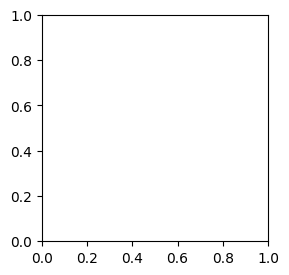

In [15]:
# Visuals
plt.figure(figsize=(10, 10))
i = 0
for image, label in trainData.take(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image.numpy().astype("uint8"))
  plt.title(str(label.numpy()))
  plt.axis("off")
  i += 1


In [47]:
inputLayer = tf.keras.layers.Input(shape=(360, 360, 3))

baseLayers = tf.keras.layers.Rescaling(1./255)(inputLayer)
baseLayers = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(baseLayers)
baseLayers = tf.keras.layers.MaxPooling2D((2, 2))(baseLayers)
baseLayers = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(baseLayers)
baseLayers = tf.keras.layers.MaxPooling2D((2, 2))(baseLayers)
baseLayers = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(baseLayers)
baseLayers = tf.keras.layers.Flatten()(baseLayers)
baseLayers = tf.keras.layers.Dense(128, activation='relu')(baseLayers)

labelOutput = tf.keras.layers.Dense(len(labelTuple))(baseLayers)
cellShapeOutput = tf.keras.layers.Dense(len(cellShapeTuple))(baseLayers)
nucleusShapeOutput = tf.keras.layers.Dense(len(nucleusShapeTuple))(baseLayers)
cytoplasmVacuoleOutput = tf.keras.layers.Dense(len(cytoplasmVacuoleTuple))(baseLayers)

model = tf.keras.Model(
	inputs=inputLayer, 
	outputs={
    "labelOutput": labelOutput,
    "cellShapeOutput": cellShapeOutput,
    "nucleusShapeOutput": nucleusShapeOutput,
    "cytoplasmVacuoleOutput": cytoplasmVacuoleOutput
	}
)

model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss={
    "labelOutput": tf.keras.losses.SparseCategoricalCrossentropy(),
    "cellShapeOutput": tf.keras.losses.SparseCategoricalCrossentropy(),
    "nucleusShapeOutput": tf.keras.losses.SparseCategoricalCrossentropy(),
    "cytoplasmVacuoleOutput": tf.keras.losses.SparseCategoricalCrossentropy()
	}
)

model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 360, 360,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_10        │ (None, 360, 360,  │          0 │ input_layer_10[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 360, 360,  │        896 │ rescaling_10[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 180, 180,  │          0 │ conv2d_30[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 180, 180,  │     18,496 │ max_pooling2d_20… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 90, 90,    │          0 │ conv2d_31[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 90, 90,    │     73,856 │ max_pooling2d_21… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 1036800)   │          0 │ conv2d_32[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 128)       │ 132,710,5… │ flatten_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 2)         │        258 │ dense_46[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 2)         │        258 │ dense_46[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 5)         │        645 │ dense_46[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 6)         │        774 │ dense_46[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 132,805,711 (506.61 MB)

 Trainable params: 132,805,711 (506.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
  trainData,
  validation_data=valData,
  epochs=10,
	batch_size=100,
	validation_steps=1
)


Epoch 1/10


I0000 00:00:1755252643.785971  648131 service.cc:145] XLA service 0x7f1ad8089900 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755252643.786047  648131 service.cc:153]   StreamExecutor device (0): AMD Radeon RX 7900 XTX, AMDGPU ISA version: gfx1100
2025-08-15 20:10:43.940708: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


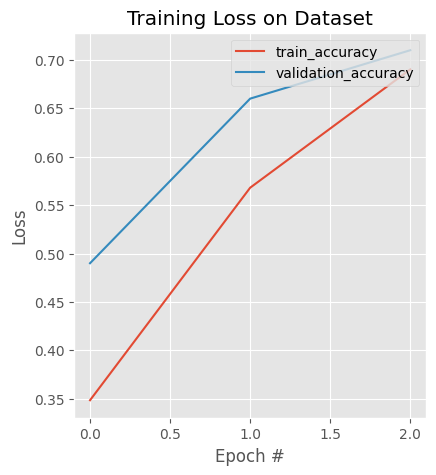

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
test accuracy: $[ 0.8182536 -4.1110735 -2.8892348 -1.2795702 -9.311018 ]


In [106]:
plt.style.use("ggplot")
plt.figure(figsize=(10,5))
Nepoch=3
plt.subplot(1,2,1)
plt.plot(np.arange(0, Nepoch), history.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, Nepoch), history.history["val_accuracy"], label="validation_accuracy")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

print(f'test accuracy: ${model.predict(valData)[1]}')